In [2]:
import pandas as pd

In [3]:
df=pd.read_csv("cardio_train_clean.csv",sep=",")
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65461,57,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
65462,61,1,158,126.0,140,90,2,2,0,0,1,1,50.472681
65463,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
65464,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


In [4]:
#Remove Height and Weight column as BMI column is there
df["BMI"] = df["weight"] / ( (df["height"]/100)**2 )
df.drop(columns=['height','weight'],inplace=True)

In [5]:
df

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,110,80,1,1,0,0,1,0,21.967120
1,55,1,140,90,3,1,0,0,1,1,34.927679
2,51,1,130,70,3,1,0,0,0,1,23.507805
3,48,2,150,100,1,1,0,0,1,1,28.710479
4,47,1,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...
65461,57,1,150,80,1,1,0,0,1,1,29.384757
65462,61,1,140,90,2,2,0,0,1,1,50.472681
65463,52,2,180,90,3,1,0,1,0,1,31.353579
65464,61,1,135,80,1,2,0,0,0,1,27.099251


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

# -------------------------------
# Features
# -------------------------------
numeric_features = ['age', 'ap_hi', 'ap_lo', 'BMI']
categorical_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

X = df[numeric_features + categorical_features + binary_features]
y = df['cardio']

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Preprocessing Pipeline
# -------------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('bin', 'passthrough', binary_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# -------------------------------
# Hyperparameter Tuning using GridSearchCV
# -------------------------------
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 5, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("Best Hyperparameters:", grid.best_params_)

# -------------------------------
# Evaluate Train vs Test (Over/Underfitting)
# -------------------------------
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

# Other metrics
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# -------------------------------
# Save model
# -------------------------------
with open("model.pkl", "wb") as f:
    pickle.dump({
        "model": best_model,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "best_params": grid.best_params_
    }, f)

print("Model saved successfully!")


Best Hyperparameters: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Training Accuracy: 0.7259795310471244
Testing Accuracy: 0.720177180387964
Precision: 0.755586112066002
Recall: 0.6622476649593251
F1 Score: 0.705844572896596
Model saved successfully!


In [8]:
# Predict class labels
y_pred = model.predict(X_test)

# Predict probabilities (needed for ROC curve)
y_proba = model.predict_proba(X_test)[:, 1]


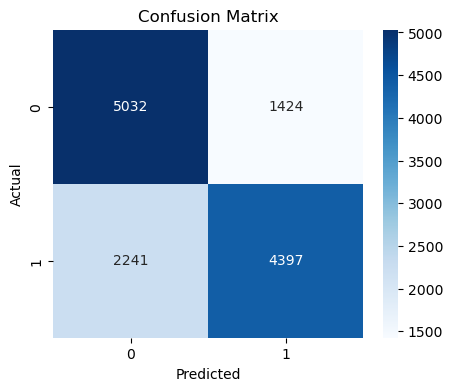

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


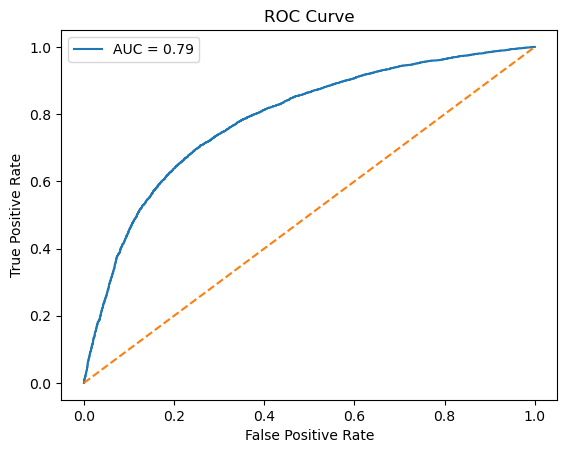

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("roc_curve.png")
plt.show()


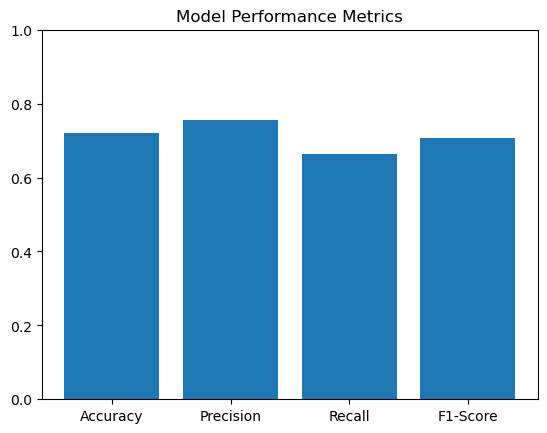

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred)
}

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0,1)
plt.title("Model Performance Metrics")
plt.savefig("metrics_bar.png")
plt.show()


In [15]:
from sklearn.metrics import accuracy_score

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)


Training Accuracy: 0.7259031543572901
Testing Accuracy: 0.7201008095310829
